## Hyperparameter tuning with Optuna

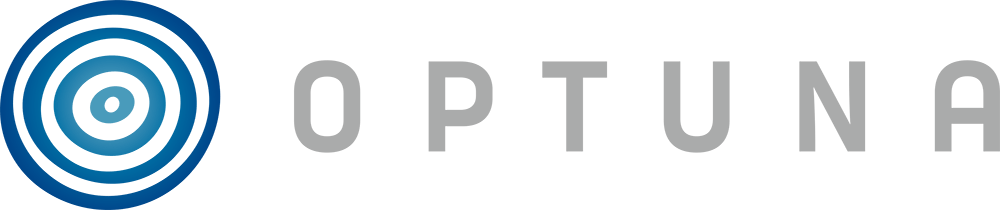

In [1]:
%%capture

!apt-get update && apt-get install -y xvfb
!pip install swig
!pip install gym[box2d]==0.23.1 pytorch-lightning==1.6.0 pyvirtualdisplay optuna==2.7.0

#### Setup virtual display

In [2]:
!pip uninstall -y tensorboard
!pip install tensorboardX

In [3]:
!pip install numpy==1.23.5

In [4]:
!pip install box2d pygame

In [5]:
!pip install optuna

In [6]:
!pip install pyvirtualdisplay
!pip install pytorch_lightning
!pip install lightning

In [7]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [8]:
import copy
import gym
import torch
import random
import statistics
import optuna
import lightning

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import LightningModule #Fixed: removed Trainer from import
import pytorch_lightning as pl

from optuna.integration import PyTorchLightningPruningCallback

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [9]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the Deep Q-Network

In [10]:
class DQN(nn.Module):
    def __init__(self, hidden_size, obs_size, n_actions): # hs -> number of units in the hidden layers, obs -> features of states
        super().__init__()
        self.net = nn.Sequential(
          nn.Linear(obs_size, hidden_size), # input, output
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size), # input, output
          nn.ReLU(),
          nn.Linear(hidden_size, n_actions) # input, output
        )

    def forward(self, x): # x is a tensor of values
        return self.net(x.float())

#### Create the policy

In [11]:
def epsilon_greedy(state, env, net, epsilon=0.0):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        state = torch.tensor([state]).to(device)
        q_values = net(state)
        _, action = torch.max(q_values, dim=1)
        action = int(action.item())
    return action

#### Create the replay buffer

In [12]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [13]:
class RLDataset(IterableDataset):
    def __init__(self, buffer, sample_size=200):
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self):
        for experience in self.buffer.sample(self.sample_size):
            yield experience

#### Create the environment

In [14]:
def create_environment(name):
    env = gym.make(name)
    env = TimeLimit(env, max_episode_steps=400)
    env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x % 50 == 0)
    env = RecordEpisodeStatistics(env)
    return env

#### Create the test/sampling function

In [15]:
print(np.__version__)  # Check NumPy version
print(optuna.__version__)  # Check Optuna version

1.23.5
4.2.1


#### Create the Deep Q-Learning algorithm

In [22]:
class DeepQLearning(LightningModule):
    def __init__(self, env_name, policy=epsilon_greedy, capacity=100_000,
                 batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99,
                 loss_fn=F.smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.15,
                 eps_last_episode=100, samples_per_epoch=10_000, sync_rate=10):
        super().__init__()
        self.env = create_environment(env_name)

        obs_size = self.env.observation_space.shape[0]
        n_actions = self.env.action_space.n

        self.q_net = DQN(hidden_size, obs_size, n_actions)

        self.target_q_net = copy.deepcopy(self.q_net)

        self.policy = policy
        self.buffer = ReplayBuffer(capacity=capacity)

        self.save_hyperparameters()

        while len(self.buffer) < self.hparams.samples_per_epoch:
            print(f"{len(self.buffer)} samples in experience buffer. Filling. . .")
            self.play_episode(epsilon=self.hparams.eps_start)

    @torch.no_grad
    def play_episode(self, policy=None, epsilon=0):
        state = self.env.reset()
        done = False

        while not done:
            if policy:
                action = policy(state, self.env, self.q_net, epsilon=epsilon)
            else:
                action = self.env.action_space.sample()

            next_state, reward, done, info =self.env.step(action)
            exp = (state, action, reward, done, next_state)
            self.buffer.append(exp)
            state = next_state

    # forward
    def forward(self, x):
        return self.q_net(x)

    # configure optimizers
    def configure_optimizers(self):
        q_net_optimizer = self.hparams.optim(self.q_net.parameters(), lr=self.hparams.lr)
        return [q_net_optimizer]

    # create dtaloader -> fetching data from dataset into training step
    def train_dataloader(self):
        dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.hparams.batch_size
        )
        return dataloader

    # Training step
    def training_step(self, batch, batch_idx):
        states, actions, rewards, dones, next_states = batch
        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)

        state_action_values = self.q_net(states).gather(1, actions) # getting the q value for the action that agent took

        next_action_values, indices = self.target_q_net(next_states).max(dim=1, keepdim=True) # getting the highest q value for that state and their indices
        next_action_values[dones] = 0.0 # ?

        expected_state_action_values = rewards + self.hparams.gamma * next_action_values # estimates

        loss = self.hparams.loss_fn(state_action_values, expected_state_action_values) # diff estimate and real value
        self.log('Episode/Q-Error', loss)
        return loss

    # Training epoch end
    def on_train_epoch_end(self):
        epsilon = max(
            self.hparams.eps_end,
            self.hparams.eps_start - self.current_epoch / self.hparams.eps_last_episode
        )
        self.log(f'Training/epsilon', epsilon)

        self.play_episode(policy=self.policy, epsilon=epsilon)
        self.log('episode/Return', self.env.return_queue[-1])

        #OPTUNA
        returns = list(self.env.return_queue)[-100:]
        self.log('hp_metric', statistics.mean(returns))

        if self.current_epoch % self.hparams.sync_rate == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict()) # update net every 10 epoch

#### Create the objective function

In [23]:
def objective(trial):
  lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
  gamma = trial.suggest_float('gamma', 0.0, 1.0)

  algo = DeepQLearning(env_name='LunarLander-v2', lr=lr, gamma=gamma)

  trainer = pl.Trainer(
      max_epochs=700,
  )

  callback = PyTorchLightningPruningCallback(trial, monitor='hp_metric')
  trainer.callbacks.append(callback)  # Add callback explicitly

  hyperparameters = dict(
      lr=lr,
      gamma=gamma,
  )

  trainer.logger.log_hyperparams(hyperparameters) #sends the info to visual
  trainer.fit(algo)

  return trainer.callback_metrics['hp_metric'].item()

#### Create the optimization study

In [24]:
pruner = optuna.pruners.SuccessiveHalvingPruner() #stopping the trials that are not very promising

study = optuna.create_study(
    direction='maximize', #maximize the value monitoring in objective
    pruner=pruner)

[I 2025-03-19 09:37:08,979] A new study created in memory with name: no-name-26ef0f3d-8765-4f51-bfdf-5db070120f65


#### Purge logs and run the visualization tool (Tensorboard)

In [26]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboardX
%tensorboard --logdir /content/lightning_logs/

rm: cannot remove '/content/lightning_logs/': No such file or directory
rm: cannot remove '/content/videos/': No such file or directory
The tensorboardX module is not an IPython extension.


UsageError: Line magic function `%tensorboard` not found.


#### Run the hyperparameter search

In [28]:
study.optimize(objective, n_trials=5)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for enviro

0 samples in experience buffer. Filling. . .


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


73 samples in experience buffer. Filling. . .
156 samples in experience buffer. Filling. . .
224 samples in experience buffer. Filling. . .
295 samples in experience buffer. Filling. . .
415 samples in experience buffer. Filling. . .
525 samples in experience buffer. Filling. . .
650 samples in experience buffer. Filling. . .
771 samples in experience buffer. Filling. . .
883 samples in experience buffer. Filling. . .
982 samples in experience buffer. Filling. . .
1081 samples in experience buffer. Filling. . .
1148 samples in experience buffer. Filling. . .
1230 samples in experience buffer. Filling. . .
1317 samples in experience buffer. Filling. . .
1416 samples in experience buffer. Filling. . .
1482 samples in experience buffer. Filling. . .
1564 samples in experience buffer. Filling. . .
1623 samples in experience buffer. Filling. . .
1683 samples in experience buffer. Filling. . .
1790 samples in experience buffer. Filling. . .
1864 samples in experience buffer. Filling. . .
194

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


4589 samples in experience buffer. Filling. . .


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


4684 samples in experience buffer. Filling. . .
4780 samples in experience buffer. Filling. . .
4863 samples in experience buffer. Filling. . .
4916 samples in experience buffer. Filling. . .
5021 samples in experience buffer. Filling. . .
5097 samples in experience buffer. Filling. . .
5167 samples in experience buffer. Filling. . .
5229 samples in experience buffer. Filling. . .
5313 samples in experience buffer. Filling. . .
5412 samples in experience buffer. Filling. . .
5483 samples in experience buffer. Filling. . .
5594 samples in experience buffer. Filling. . .
5666 samples in experience buffer. Filling. . .
5730 samples in experience buffer. Filling. . .
5827 samples in experience buffer. Filling. . .
5899 samples in experience buffer. Filling. . .
5964 samples in experience buffer. Filling. . .
6057 samples in experience buffer. Filling. . .
6144 samples in experience buffer. Filling. . .
6218 samples in experience buffer. Filling. . .
6325 samples in experience buffer. Filli

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


8935 samples in experience buffer. Filling. . .


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


9023 samples in experience buffer. Filling. . .
9143 samples in experience buffer. Filling. . .
9213 samples in experience buffer. Filling. . .
9321 samples in experience buffer. Filling. . .
9395 samples in experience buffer. Filling. . .
9482 samples in experience buffer. Filling. . .
9587 samples in experience buffer. Filling. . .
9705 samples in experience buffer. Filling. . .
9786 samples in experience buffer. Filling. . .


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


9885 samples in experience buffer. Filling. . .
9968 samples in experience buffer. Filling. . .


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
[W 2025-03-19 12:35:32,078] Trial 8 failed with parameters: {'lr': 1.009010510986116e-05, 'gamma': 0.6140173254936966} because of the following error: NameError("name 'exit' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/call.py", line 47, in _call_and_handle_i

NameError: name 'exit' is not defined

#### Select and use the best hyperparameters

#### Check the resulting policy